# Bike Sharing in Washington D.C. Dataset (v1)

ML sample: treat the Time series analysis with Bike Sharing in Washington D.C. Dataset.

- Bike Sharing in Washington D.C. Dataset
  - https://www.kaggle.com/datasets/marklvl/bike-sharing-dataset

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import datetime

from prophet import Prophet
from sklearn.metrics import r2_score

Importing plotly failed. Interactive plots will not work.


In [2]:
# Dataset
DF_RAW = pd.read_csv(
    './bike-sharing-dataset/day.csv',
    parse_dates=[1]
)

display(DF_RAW)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


In [3]:
# Check null
DF_RAW.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [4]:
# Data preprocessing and splitting.
df_v1 = DF_RAW[
    ['dteday', 'registered']
]
df_v1.columns =[
    'ds', 'y'
]

display(df_v1.head())

,ds,y
0,2011-01-01,654
1,2011-01-02,670
2,2011-01-03,1229
3,2011-01-04,1454
4,2011-01-05,1518


In [5]:
start_date = datetime.date(2012, 10, 1)
end_date = datetime.date(2012, 12, 31)

# Days size for prediction (from October 2012 to December 2012)
days_size_for_prediction: int = (end_date - start_date).days + 1

display(days_size_for_prediction)

92

In [6]:
day_border = pd.to_datetime('2012-10-01')
index_of_train = df_v1['ds'] < day_border
index_of_test = df_v1['ds'] >= day_border

X_train = df_v1[index_of_train]
X_test = df_v1[index_of_test]
date_test = df_v1['ds'][index_of_test]

In [7]:
# Model construction
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)
model.fit(X_train)

11:20:07 - cmdstanpy - INFO - Chain [1] start processing
11:20:08 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
# Prediction data preparation
future = model.make_future_dataframe(
    periods=days_size_for_prediction,
    freq='D'
)

display(future)

,ds
0,2011-01-01
1,2011-01-02
2,2011-01-03
3,2011-01-04
4,2011-01-05
...,...
726,2012-12-27
727,2012-12-28
728,2012-12-29
729,2012-12-30


In [9]:
pred = model.predict(future)

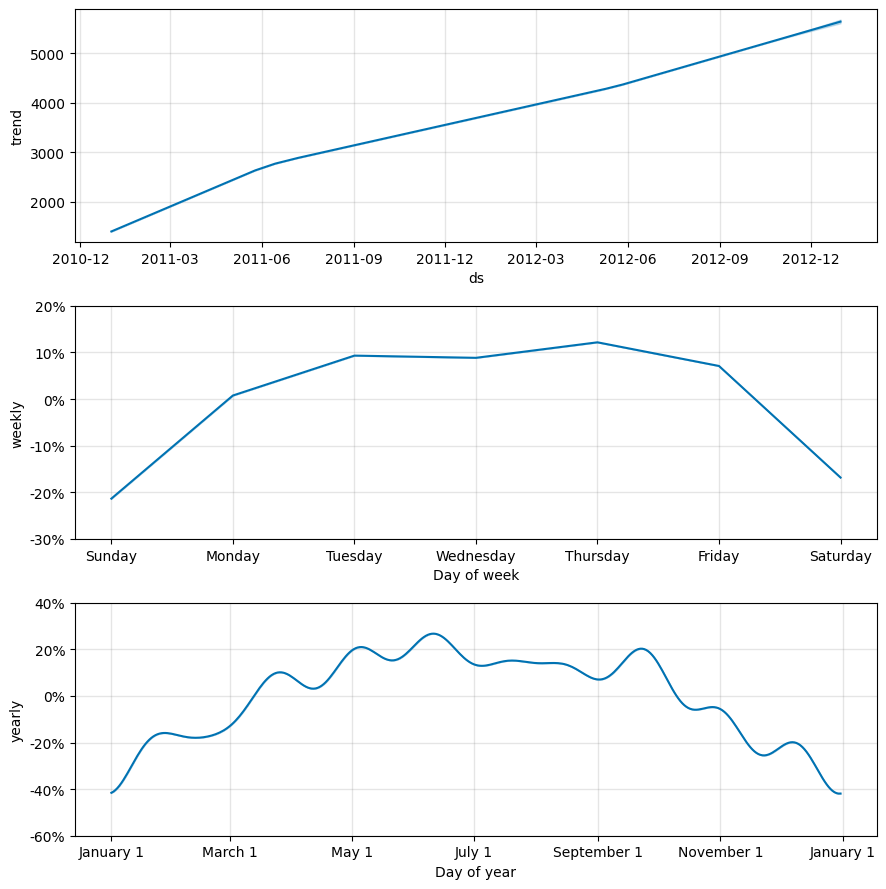

In [10]:
predict_fig = model.plot_components(pred)

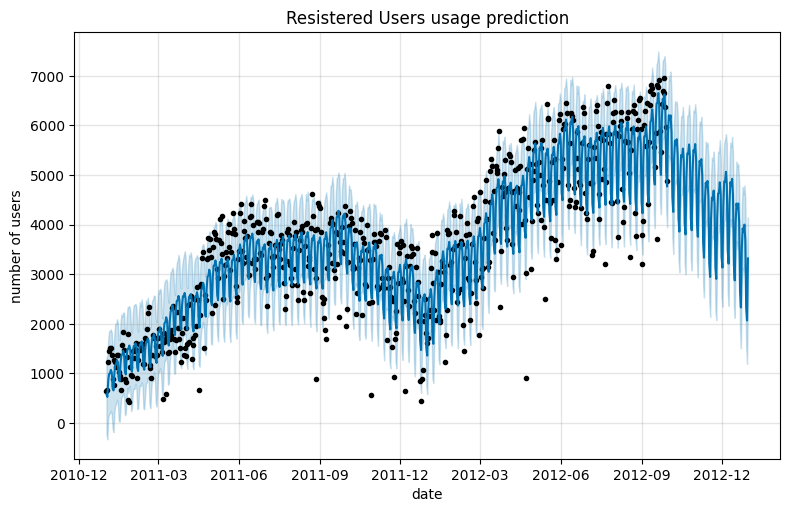

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))

model.plot(pred, ax=ax)
ax.set_title('Resistered Users usage prediction')
ax.set_xlabel('date')
ax.set_ylabel('number of users')
plt.show()

In [12]:
# R2 calcuration
y_pred = pred[-(days_size_for_prediction):][['yhat']].values
y_test = X_test['y'].values

score = r2_score(y_test, y_pred)

print(f'R2 Score: {score:.4f}')

R2 Score: 0.4076
